In [650]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from court_detector import CourtDetector
from skimage.morphology import skeletonize

In [651]:
def crop_image(img, x_ct, y_ct, crop_size=40):
    refined_x_ct, refined_y_ct = int(x_ct), int(y_ct)
    
    img_height, img_width = img.shape[:2]
    x_min = max(refined_x_ct - crop_size, 0)
    x_max = min(refined_x_ct + crop_size, img_width)
    y_min = max(refined_y_ct - crop_size, 0)
    y_max = min(refined_y_ct + crop_size, img_height)

    img_crop = img[y_min:y_max, x_min:x_max]
    return img_crop

In [652]:
def to_binary(gray_image, width, height):
    binary = np.zeros_like(gray_image)
    region_size = 80

    for y in range(0, height, region_size):
        for x in range(0, width, region_size):
            region = gray_image[y:min(y+region_size, height), x:min(x+region_size, width)]
            _, umbral_region = cv2.threshold(region, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            binary[y:min(y+region_size, height), x:min(x+region_size, width)] = umbral_region
    return binary

In [653]:
def draw_full_lines(image, lines=None):
    if lines is not None:
        for linea in lines:
            x1, y1, x2, y2 = linea
            cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 1)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


In [654]:
def detect_lines(frame):
    # Preparing the image - Preprocessing
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    height, width = gray.shape[:2]
    binary = to_binary(gray, width, height)

    # Edge detection
    canny_edges = cv2.Canny(binary, 0, 5, apertureSize=3)

    # Morphological operations
    dilation = cv2.dilate(canny_edges, np.ones((5,5), np.uint8), iterations=1)
    erosion = cv2.erode(dilation, np.ones((4,4), np.uint8), iterations=1)
    skeletonized = (skeletonize(erosion/255)*255).astype(np.uint8)

    # Hough Transform - Line Detection
    linesP = cv2.HoughLinesP(skeletonized, 1, np.pi / 180, 3, minLineLength=1, maxLineGap=5)

    # Handle the case where no lines are detected
    if linesP is not None:
        linesP = np.squeeze(linesP) 
        if len(linesP.shape) > 0:
            if len(linesP) == 4 and not isinstance(linesP[0], np.ndarray): linesP = [linesP]
        else:
            linesP = []
    else:
        linesP = []

    return linesP

In [655]:
cd = CourtDetector('../models/keypoints_model.pth')
frame = cv2.imread('../data/raw/court/test_images/_7UfL2egoN0_300.png')

In [656]:
keypoints = cd.detect(frame)
keypoints = keypoints.reshape(-1, 2)
keypoints

array([[ 395.43112,  200.53119],
       [ 880.1212 ,  200.32927],
       [ 203.4826 ,  562.7293 ],
       [1071.8365 ,  562.10974],
       [ 456.4987 ,  200.42358],
       [ 312.4672 ,  562.5695 ],
       [ 819.57416,  200.37407],
       [ 962.8312 ,  562.0665 ],
       [ 436.22116,  252.0448 ],
       [ 839.9988 ,  251.9391 ],
       [ 362.78   ,  434.4697 ],
       [ 911.93085,  434.25797],
       [ 637.35284,  252.03673],
       [ 637.16003,  434.33627]], dtype=float32)

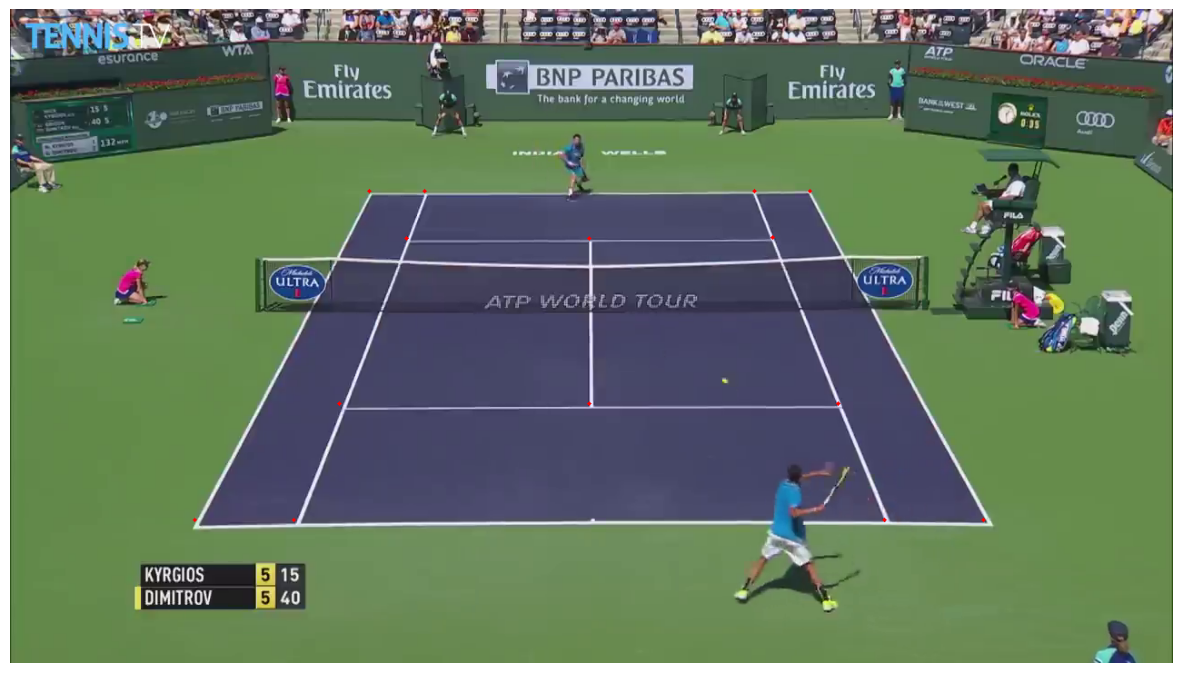

In [657]:
frame_kps = frame.copy()
for kp in keypoints:
    x, y = kp
    cv2.circle(frame_kps, (int(x), int(y)), 2, (0, 0, 255), -1)

plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(frame_kps, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


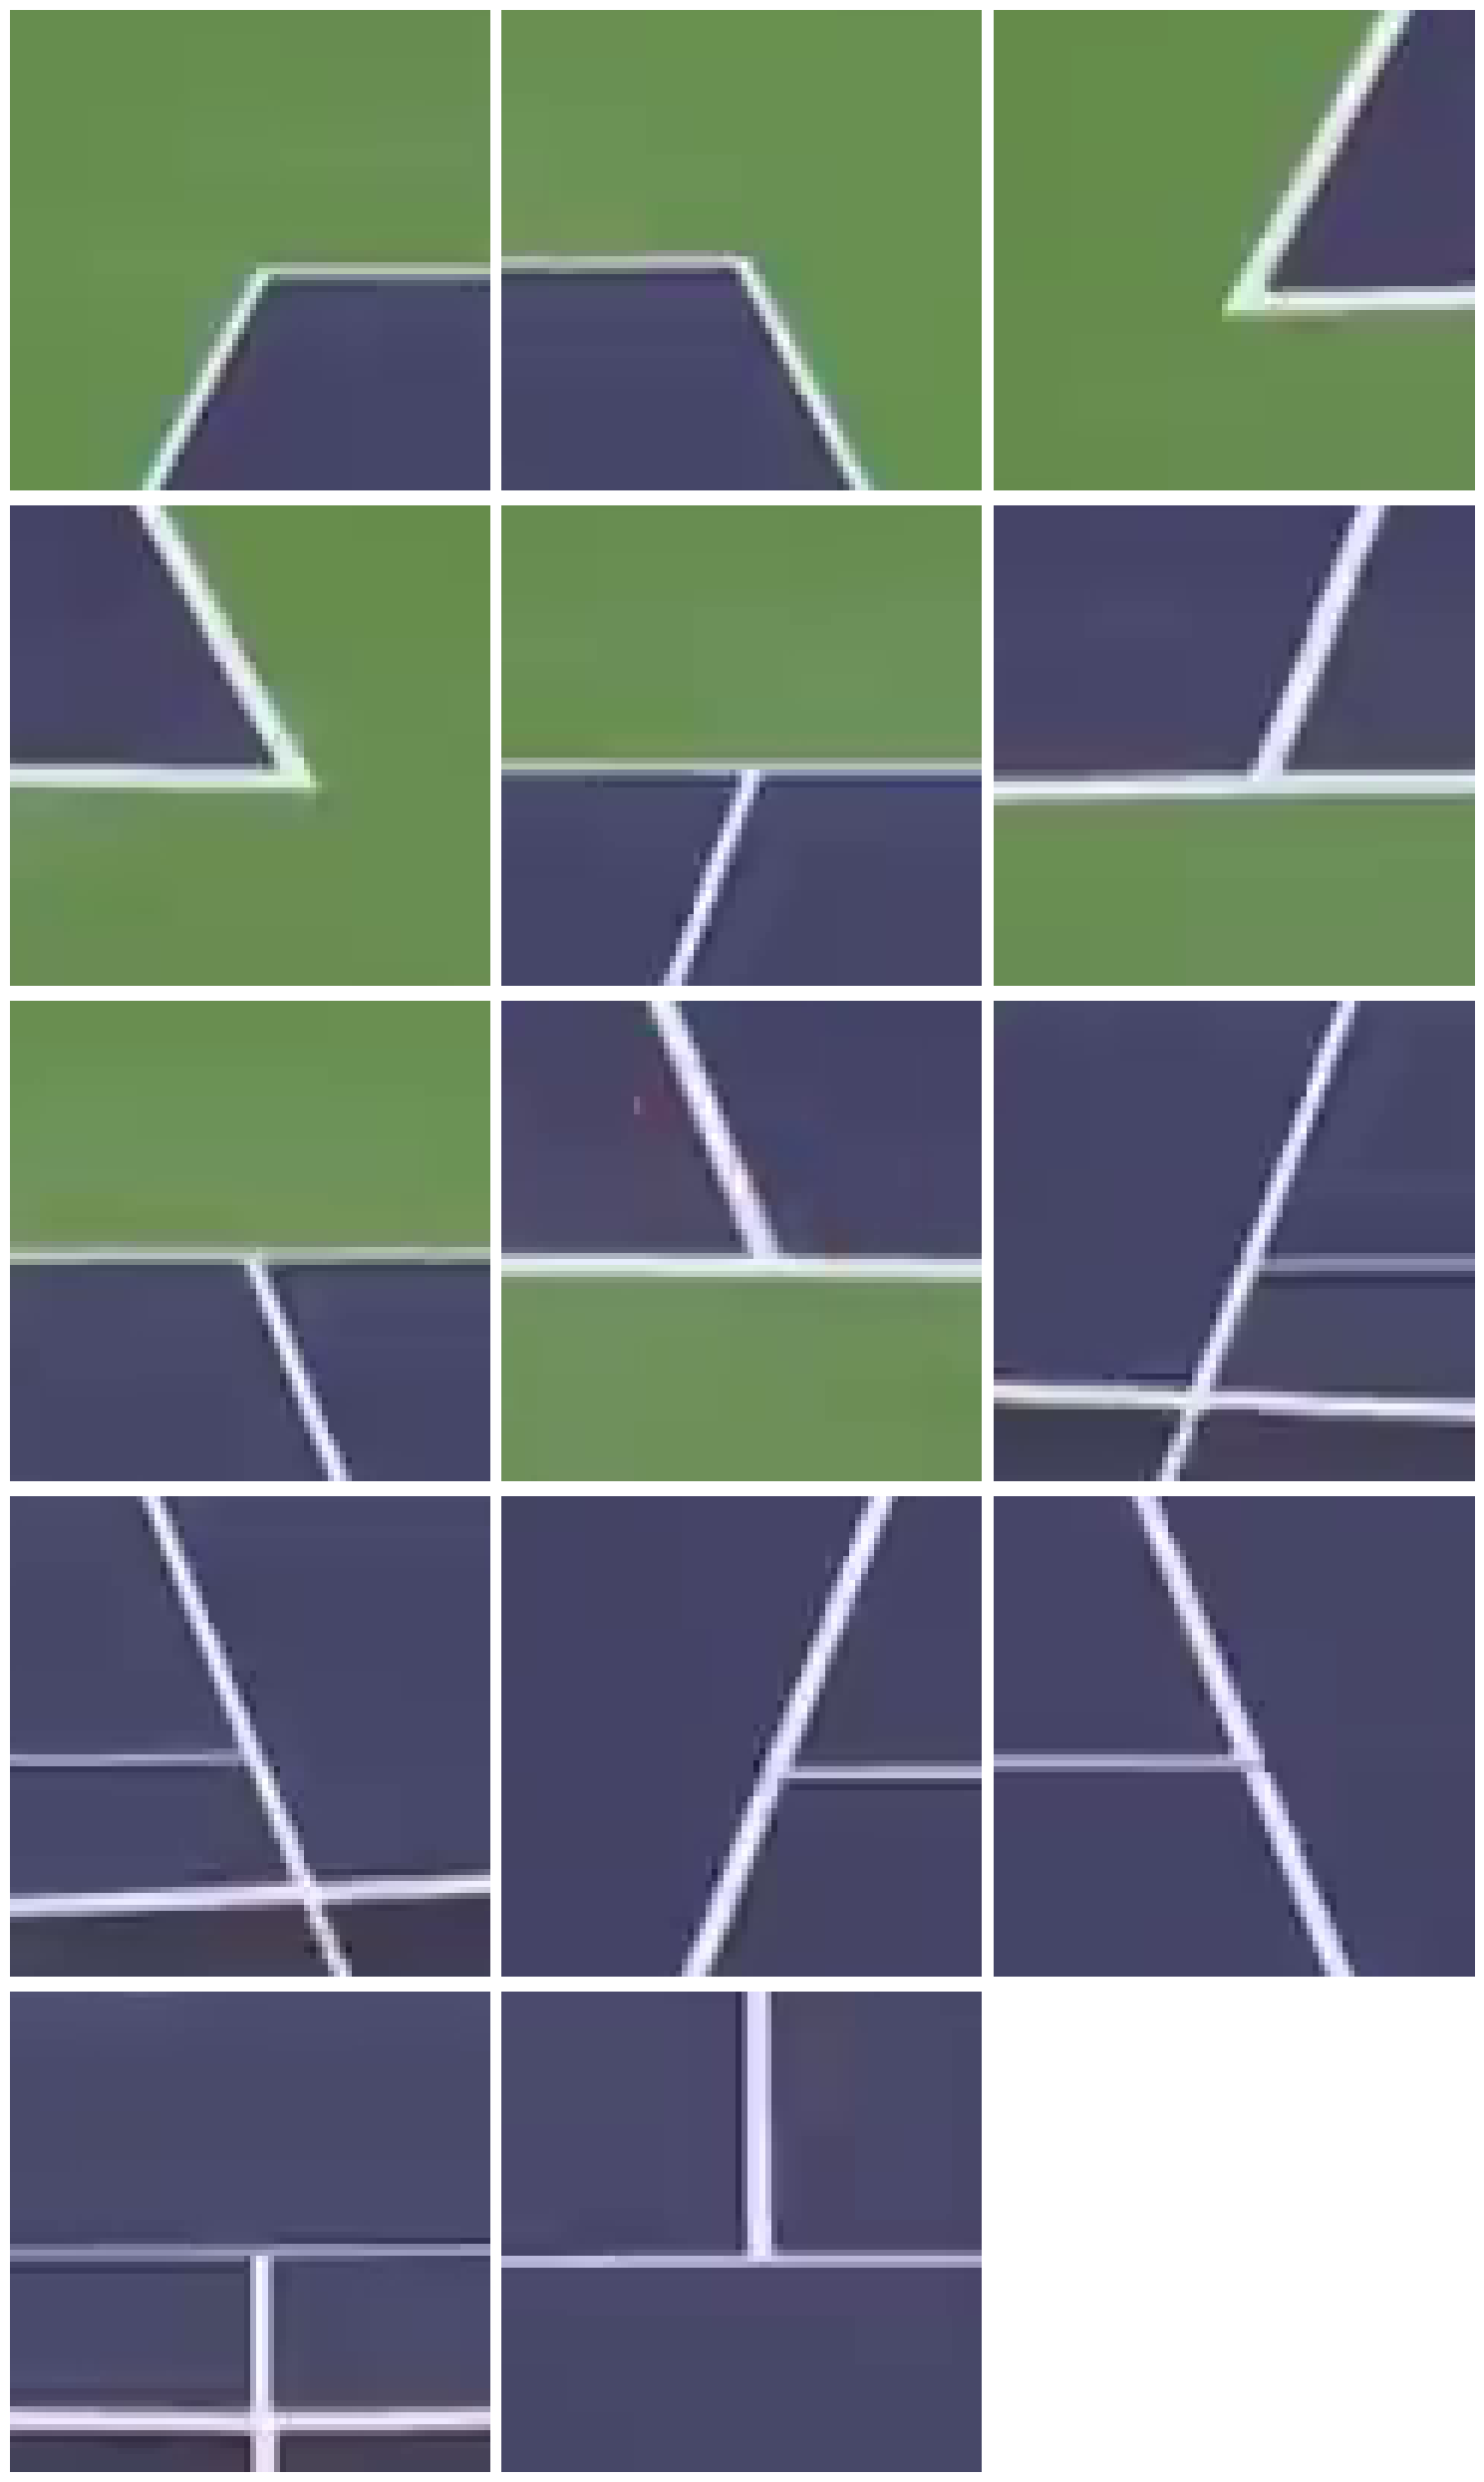

In [658]:
n_keypoints = len(keypoints)
n_cols = 3
n_rows = (n_keypoints + n_cols - 1) // n_cols

# Cropeed images around keypoints
cropped_images = []
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
for i, kp in enumerate(keypoints):
    x, y = kp
    cropped = crop_image(frame, x, y)
    cropped_images.append(cropped)
    
    row, col = divmod(i, n_cols)
    axs[row, col].imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

for j in range(i + 1, n_rows * n_cols):
    row, col = divmod(j, n_cols)
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

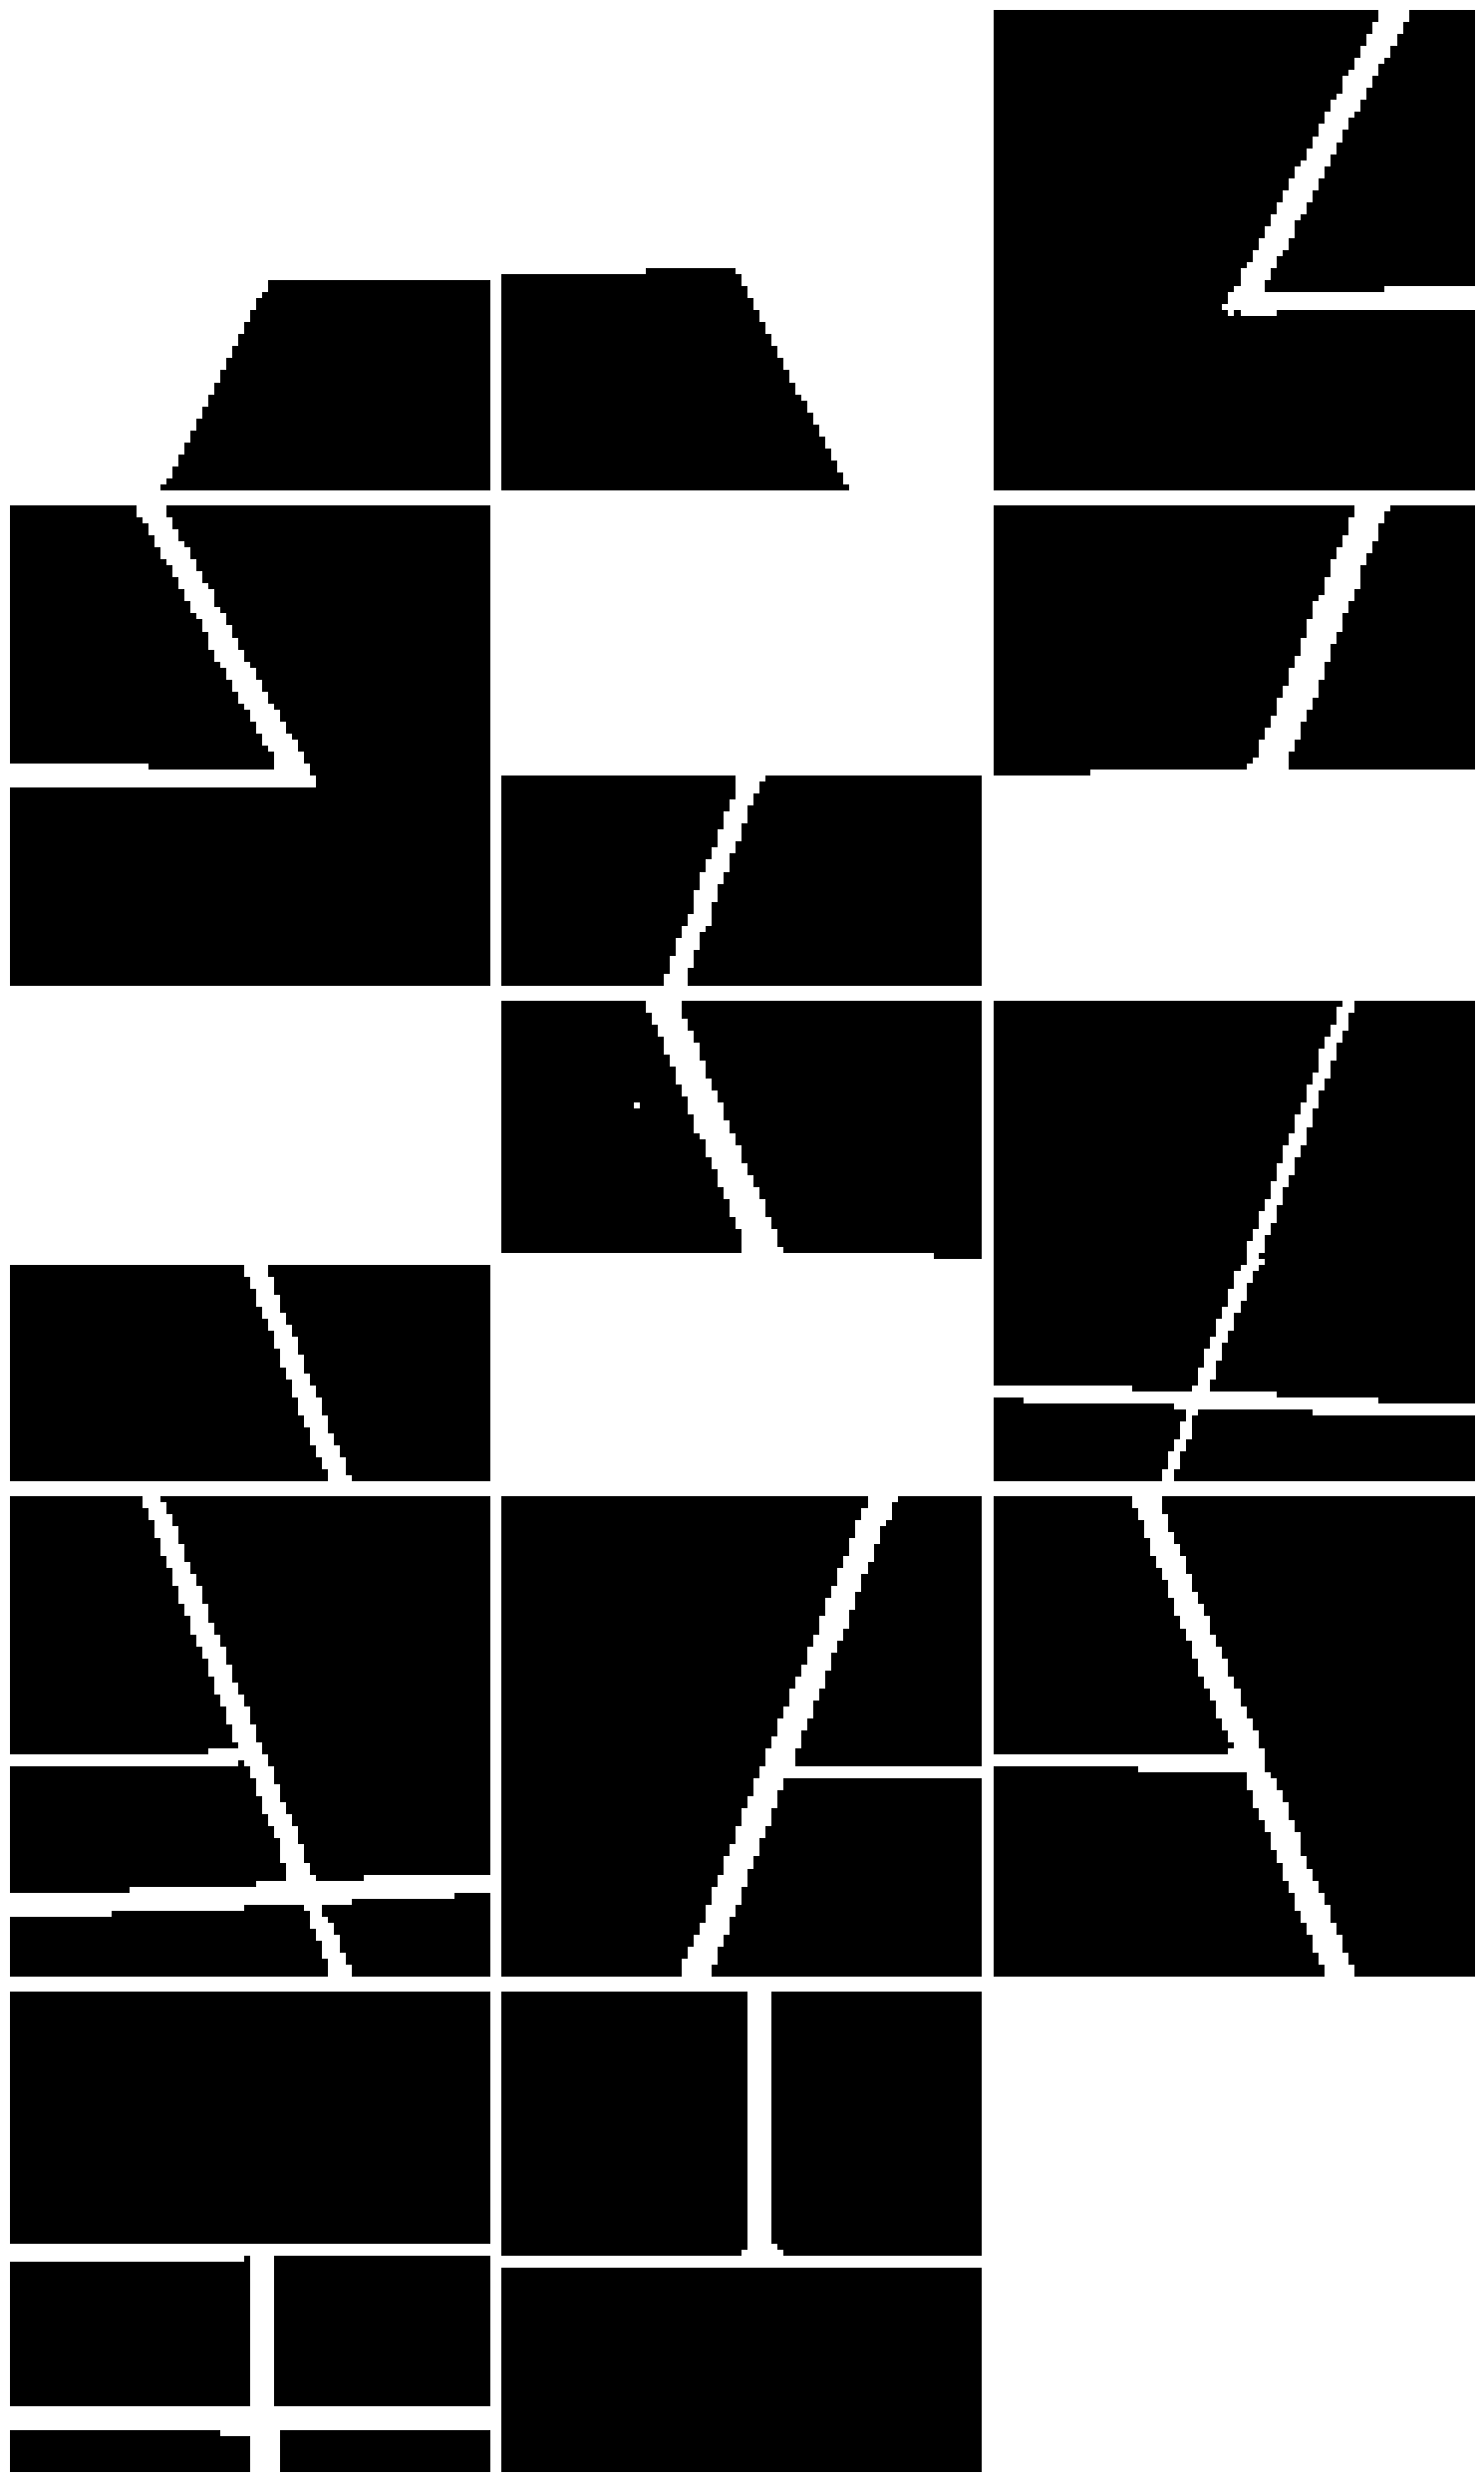

In [659]:
n_keypoints = len(keypoints)
n_cols = 3
n_rows = (n_keypoints + n_cols - 1) // n_cols

binarized_images = []
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
for i, cri in enumerate(cropped_images):

    # image quantization
    pixels = cri.reshape((-1, 3))
    pixels = np.float32(pixels)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    
    k = 3
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    quantized_pixels = centers[labels.flatten()]
    quantized_image = quantized_pixels.reshape(cri.shape)

    gray_image = cv2.cvtColor(quantized_image, cv2.COLOR_BGR2GRAY)
    binary_image = to_binary(gray_image, *gray_image.shape[:2])
    binarized_images.append(binary_image)

    row, col = divmod(i, n_cols)
    axs[row, col].imshow(binary_image, cmap='gray')
    axs[row, col].axis('off')

for j in range(i + 1, n_rows * n_cols):
    row, col = divmod(j, n_cols)
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

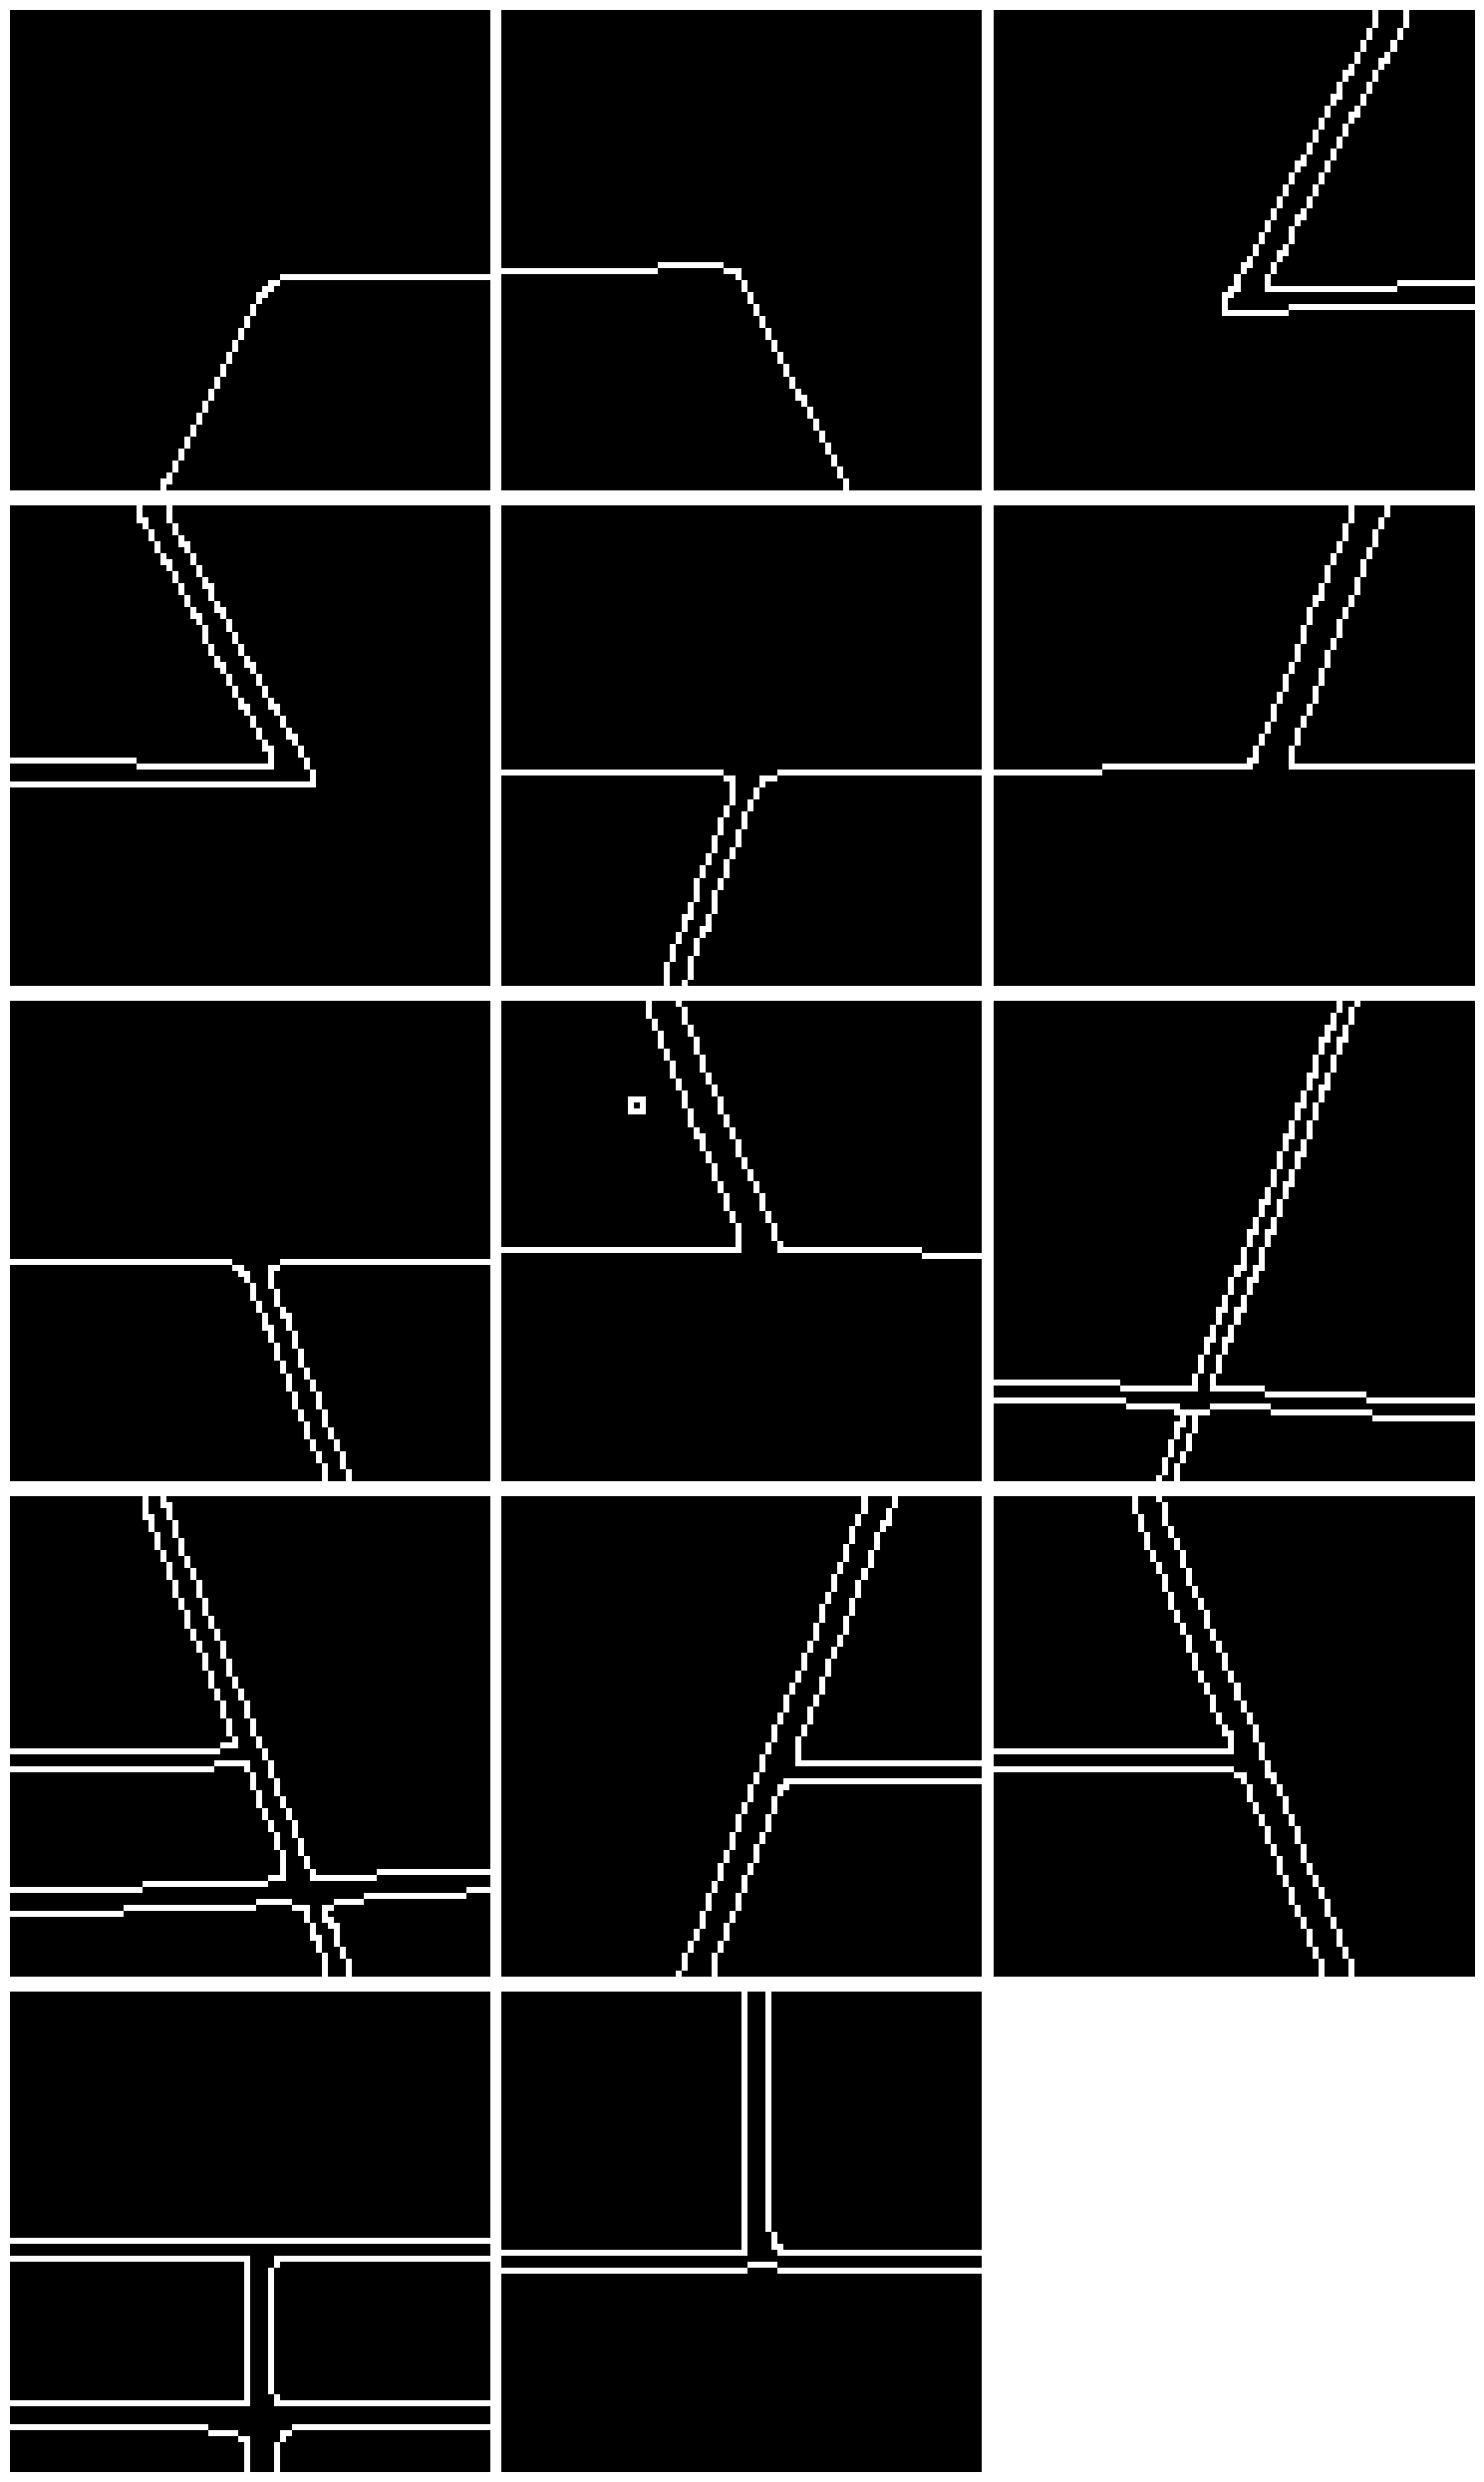

In [660]:
n_keypoints = len(keypoints)
n_cols = 3
n_rows = (n_keypoints + n_cols - 1) // n_cols

edges = []
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
for i, binarized in enumerate(binarized_images):

    # Edge detection
    canny_edges = cv2.Canny(binarized, 0, 0, apertureSize=5)
    edges.append(canny_edges)

    row, col = divmod(i, n_cols)
    axs[row, col].imshow(canny_edges, cmap='gray')
    axs[row, col].axis('off')

for j in range(i + 1, n_rows * n_cols):
    row, col = divmod(j, n_cols)
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

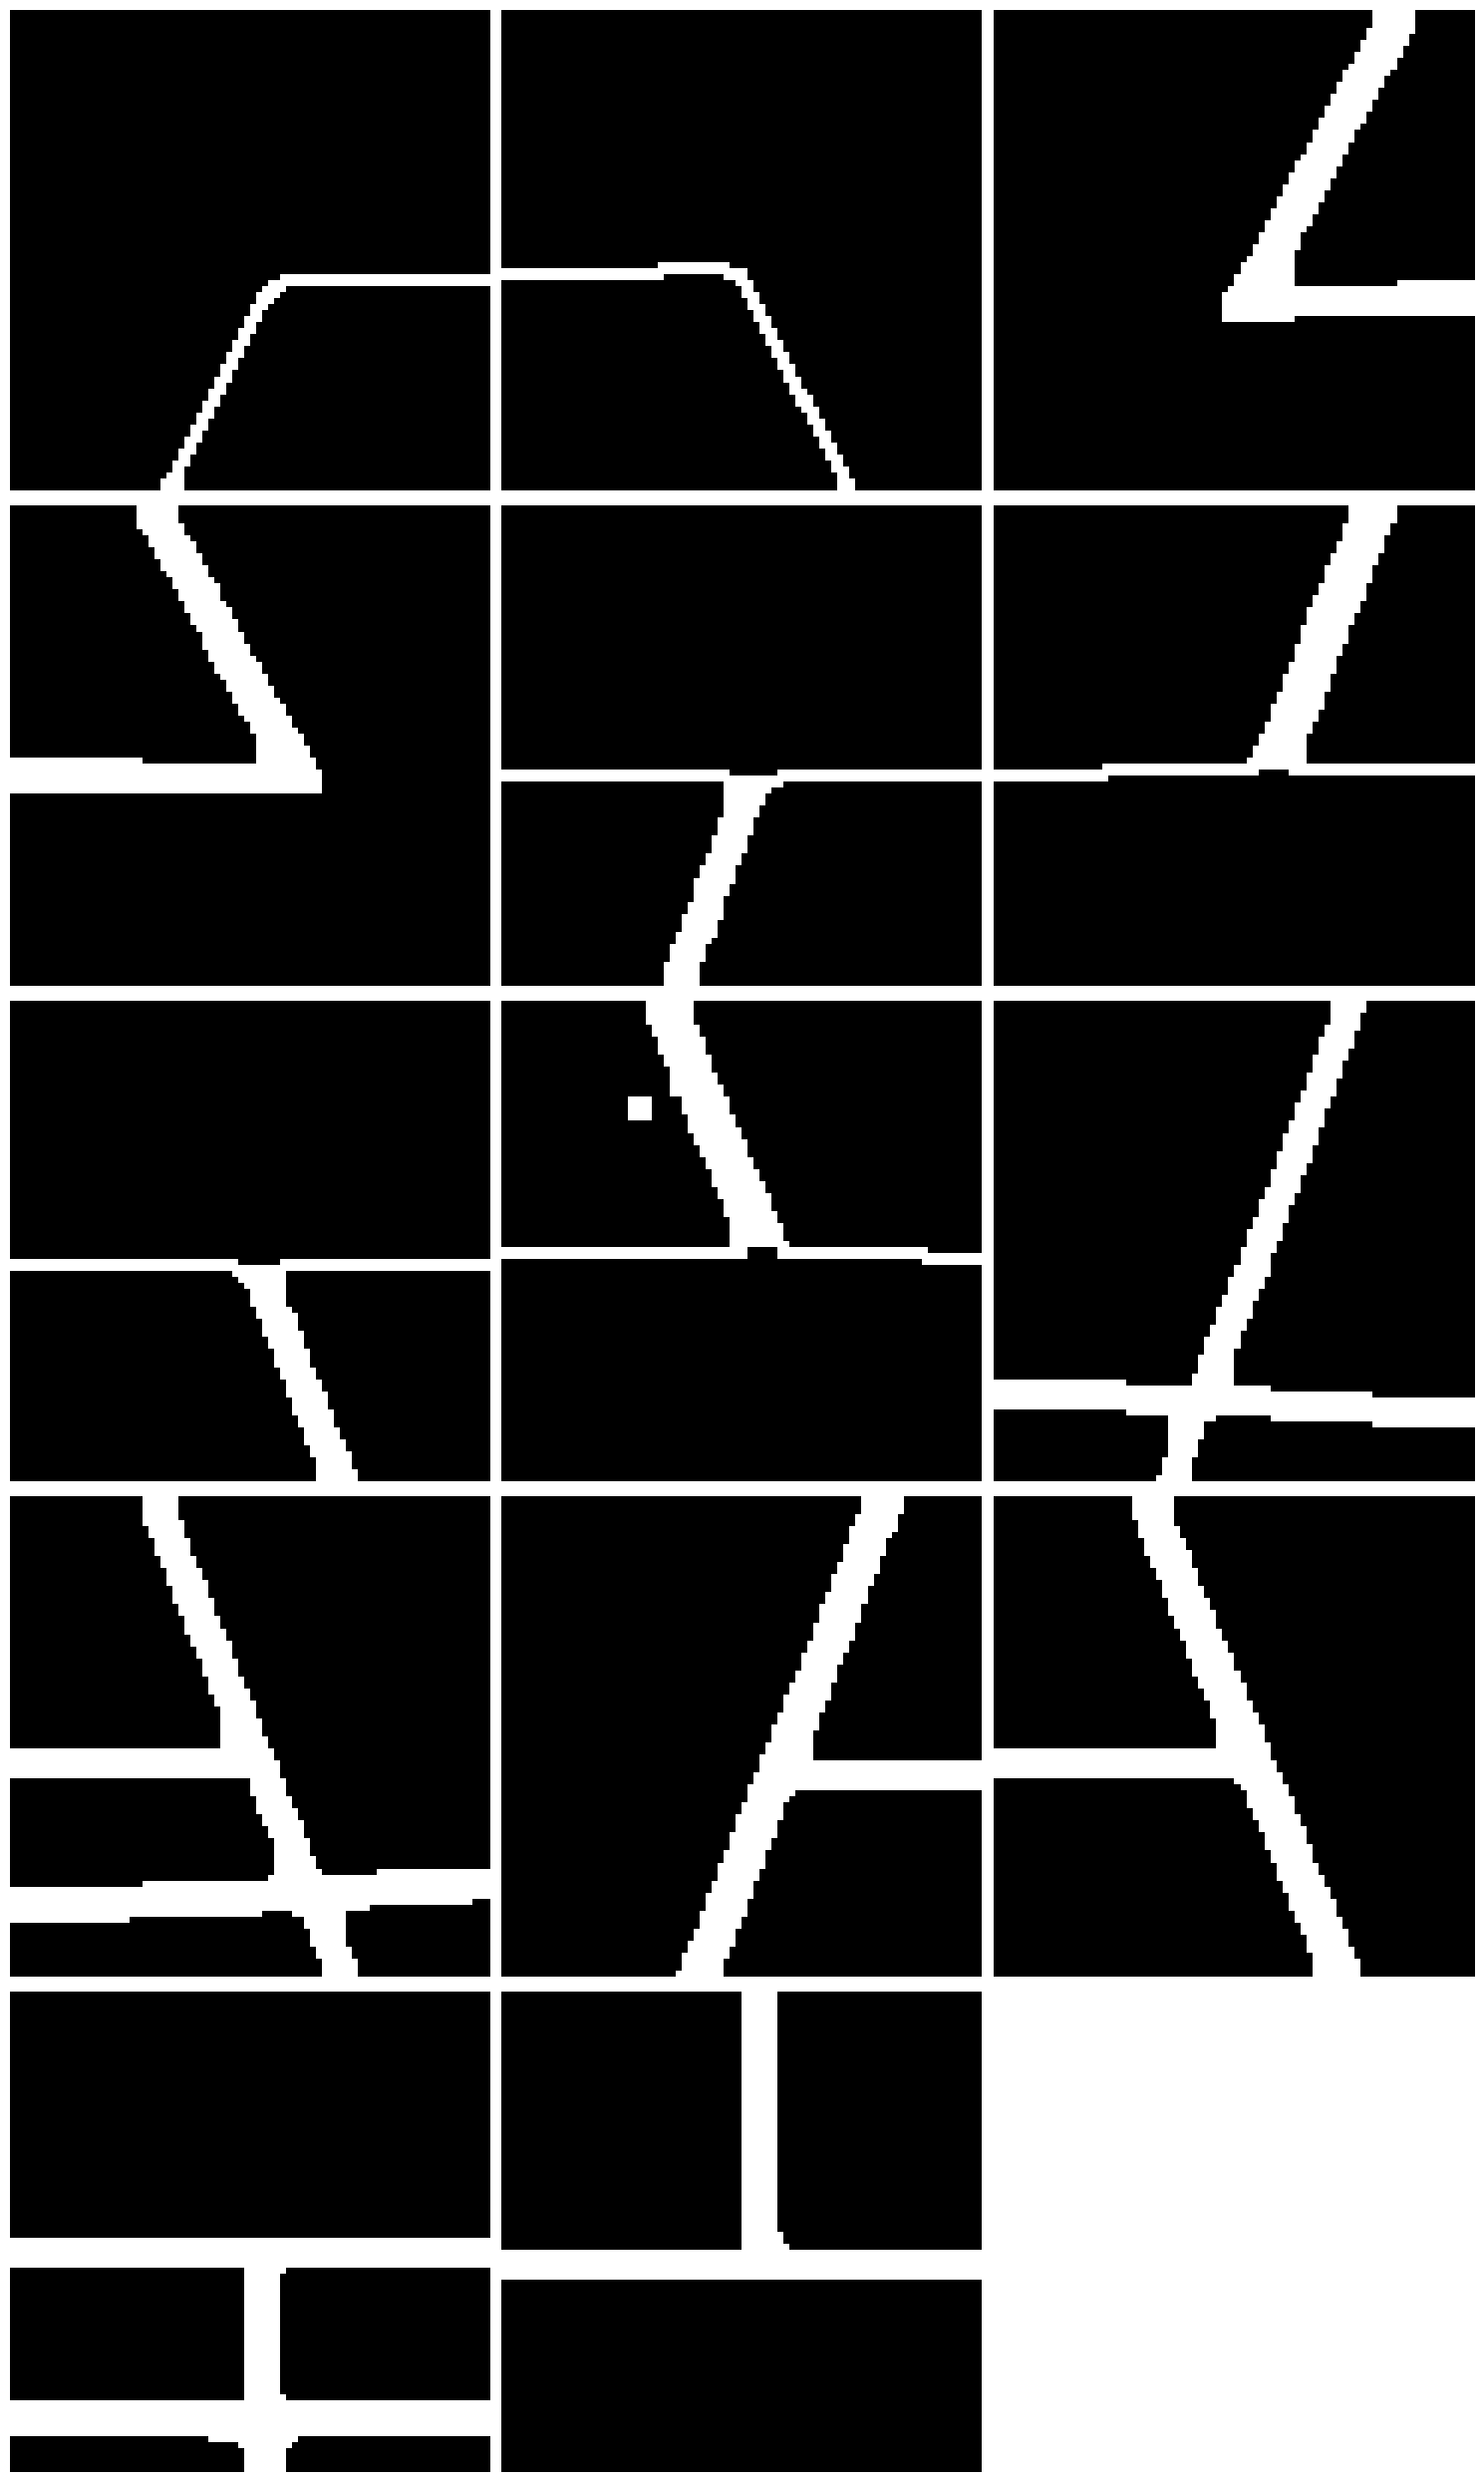

In [661]:
n_keypoints = len(keypoints)
n_cols = 3
n_rows = (n_keypoints + n_cols - 1) // n_cols

erosion_list = []
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
for i, edge in enumerate(edges):

    dilation = cv2.dilate(edges[i], np.ones((6,6), np.uint8), iterations=1)
    erosion = cv2.erode(dilation, np.ones((5,5), np.uint8), iterations=1)
    erosion_list.append(erosion)

    row, col = divmod(i, n_cols)
    axs[row, col].imshow(erosion, cmap='gray')
    axs[row, col].axis('off')

for j in range(i + 1, n_rows * n_cols):
    row, col = divmod(j, n_cols)
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

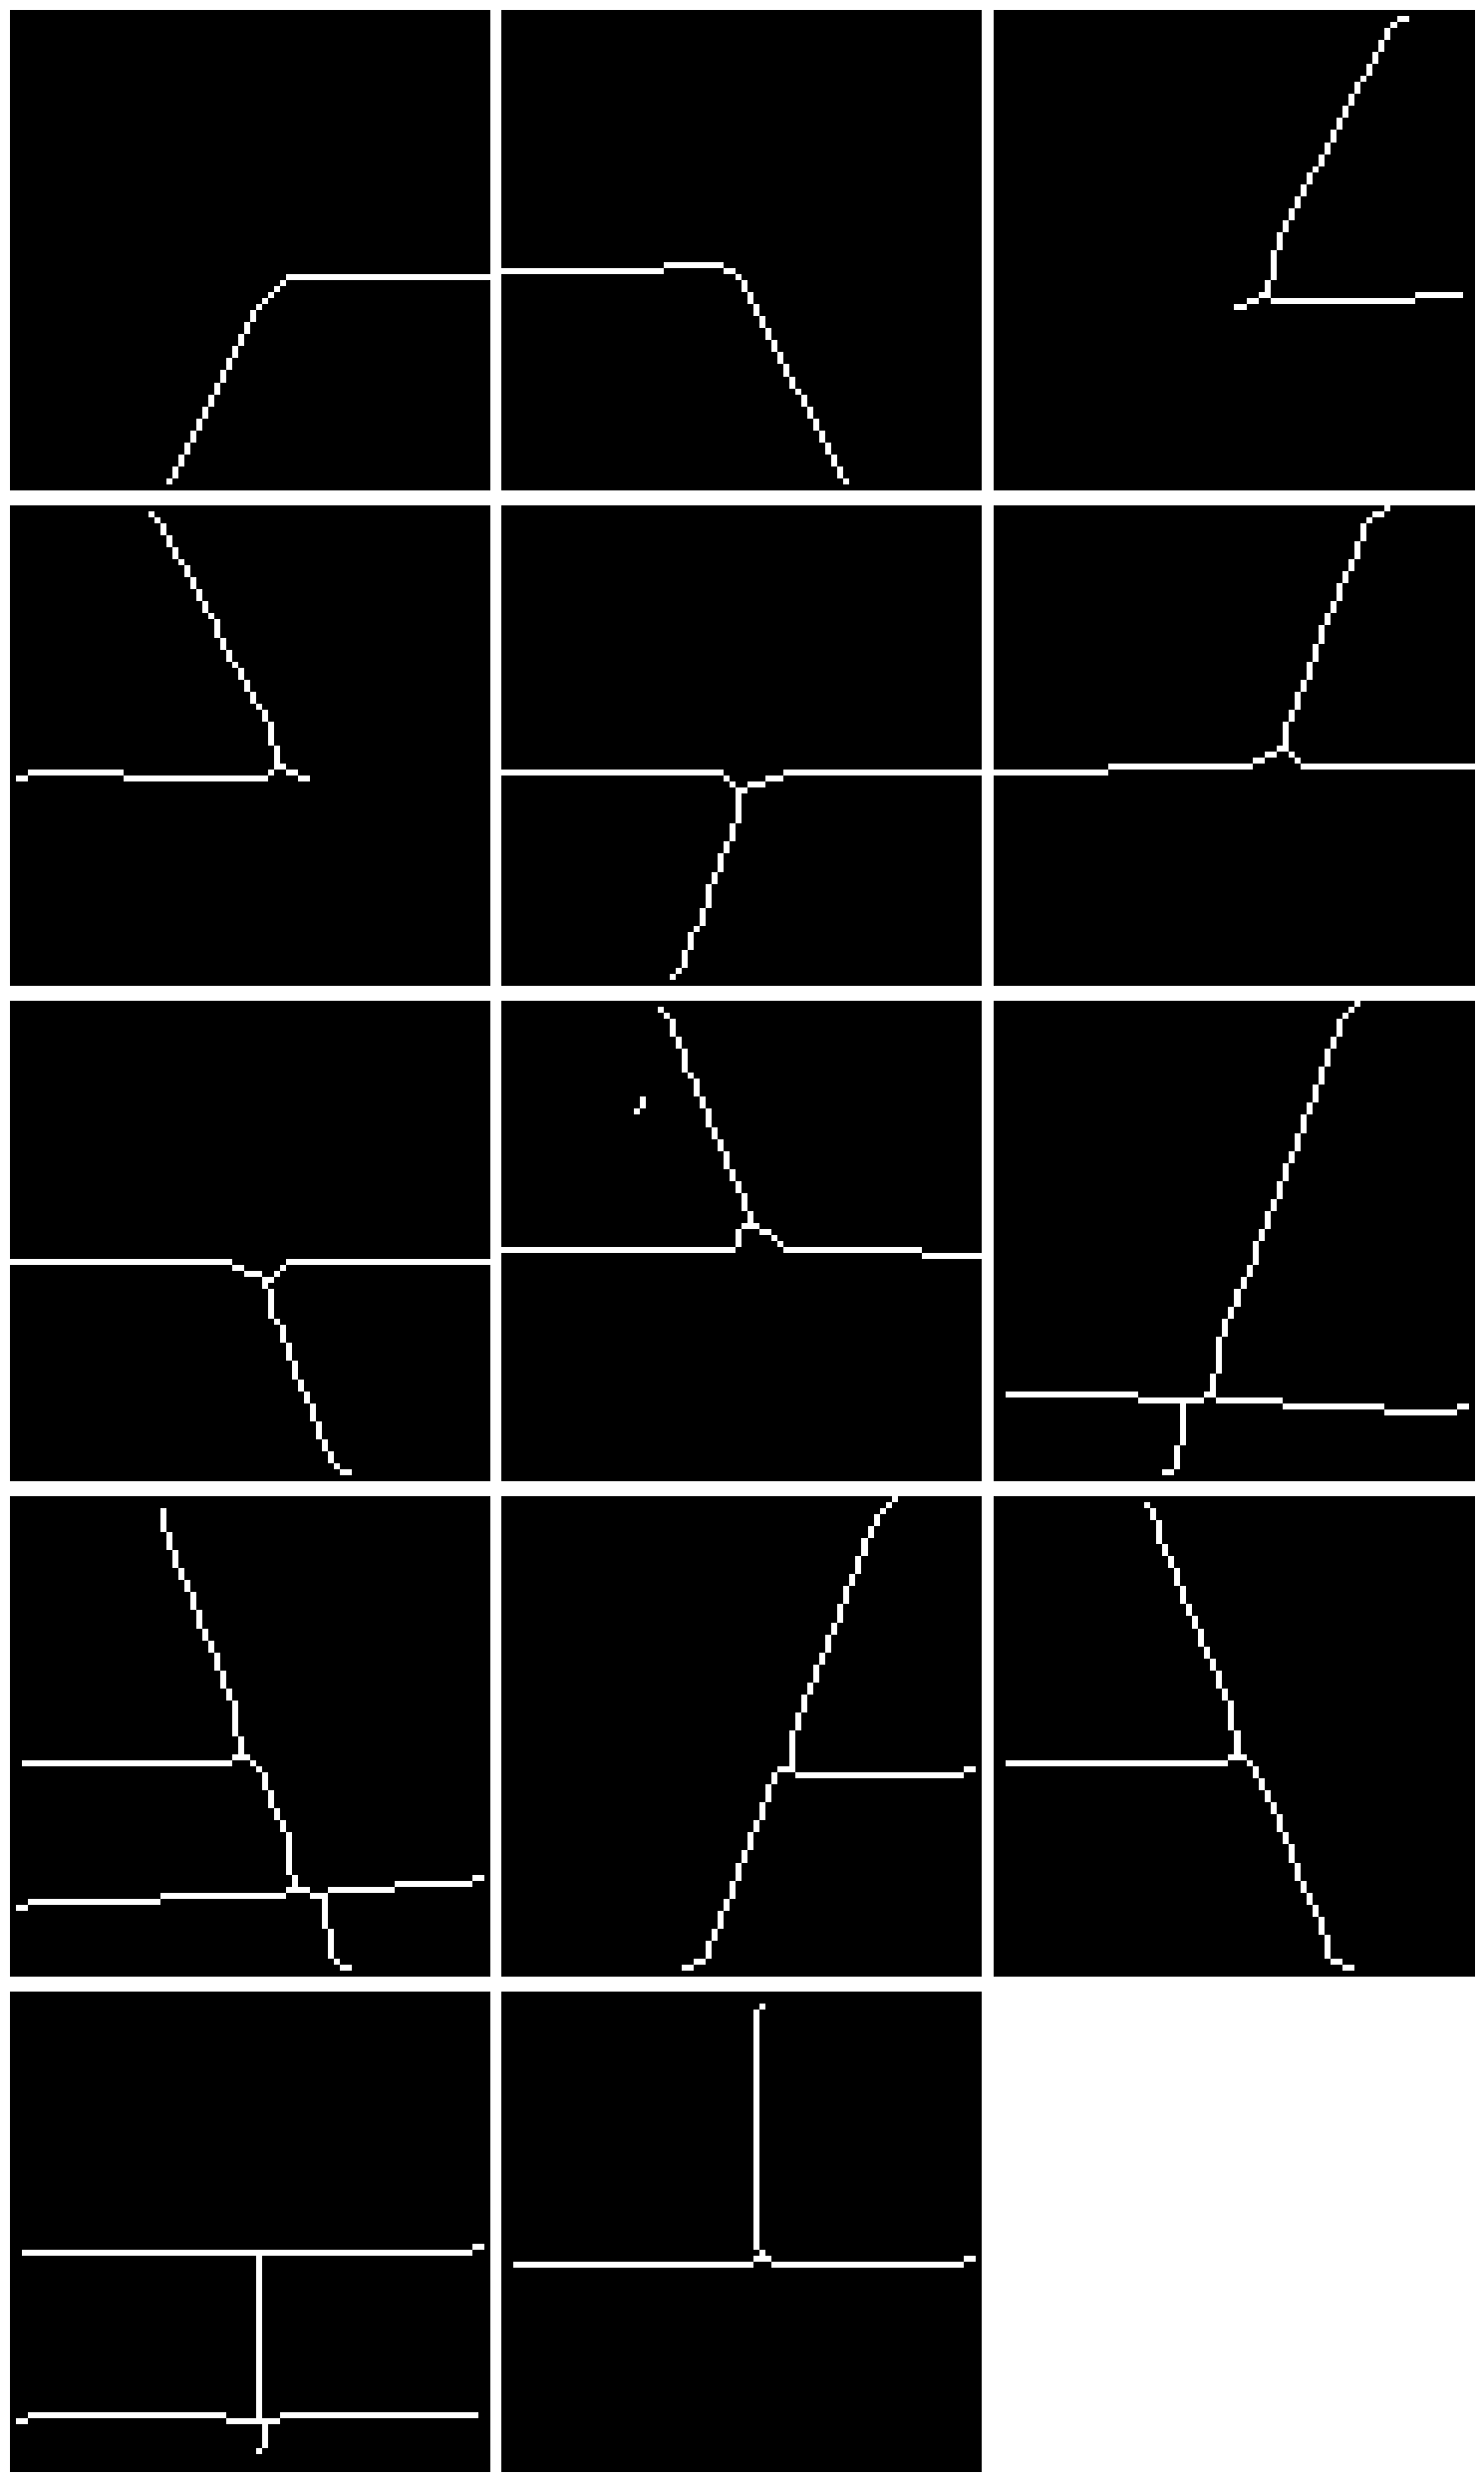

In [662]:
n_keypoints = len(keypoints)
n_cols = 3
n_rows = (n_keypoints + n_cols - 1) // n_cols

skeletons = []
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
for i, erosion_el in enumerate(erosion_list):

    skeletonized = (skeletonize(erosion_el/255)*255).astype(np.uint8)
    skeletons.append(skeletonized)

    row, col = divmod(i, n_cols)
    axs[row, col].imshow(skeletonized, cmap='gray')
    axs[row, col].axis('off')

for j in range(i + 1, n_rows * n_cols):
    row, col = divmod(j, n_cols)
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

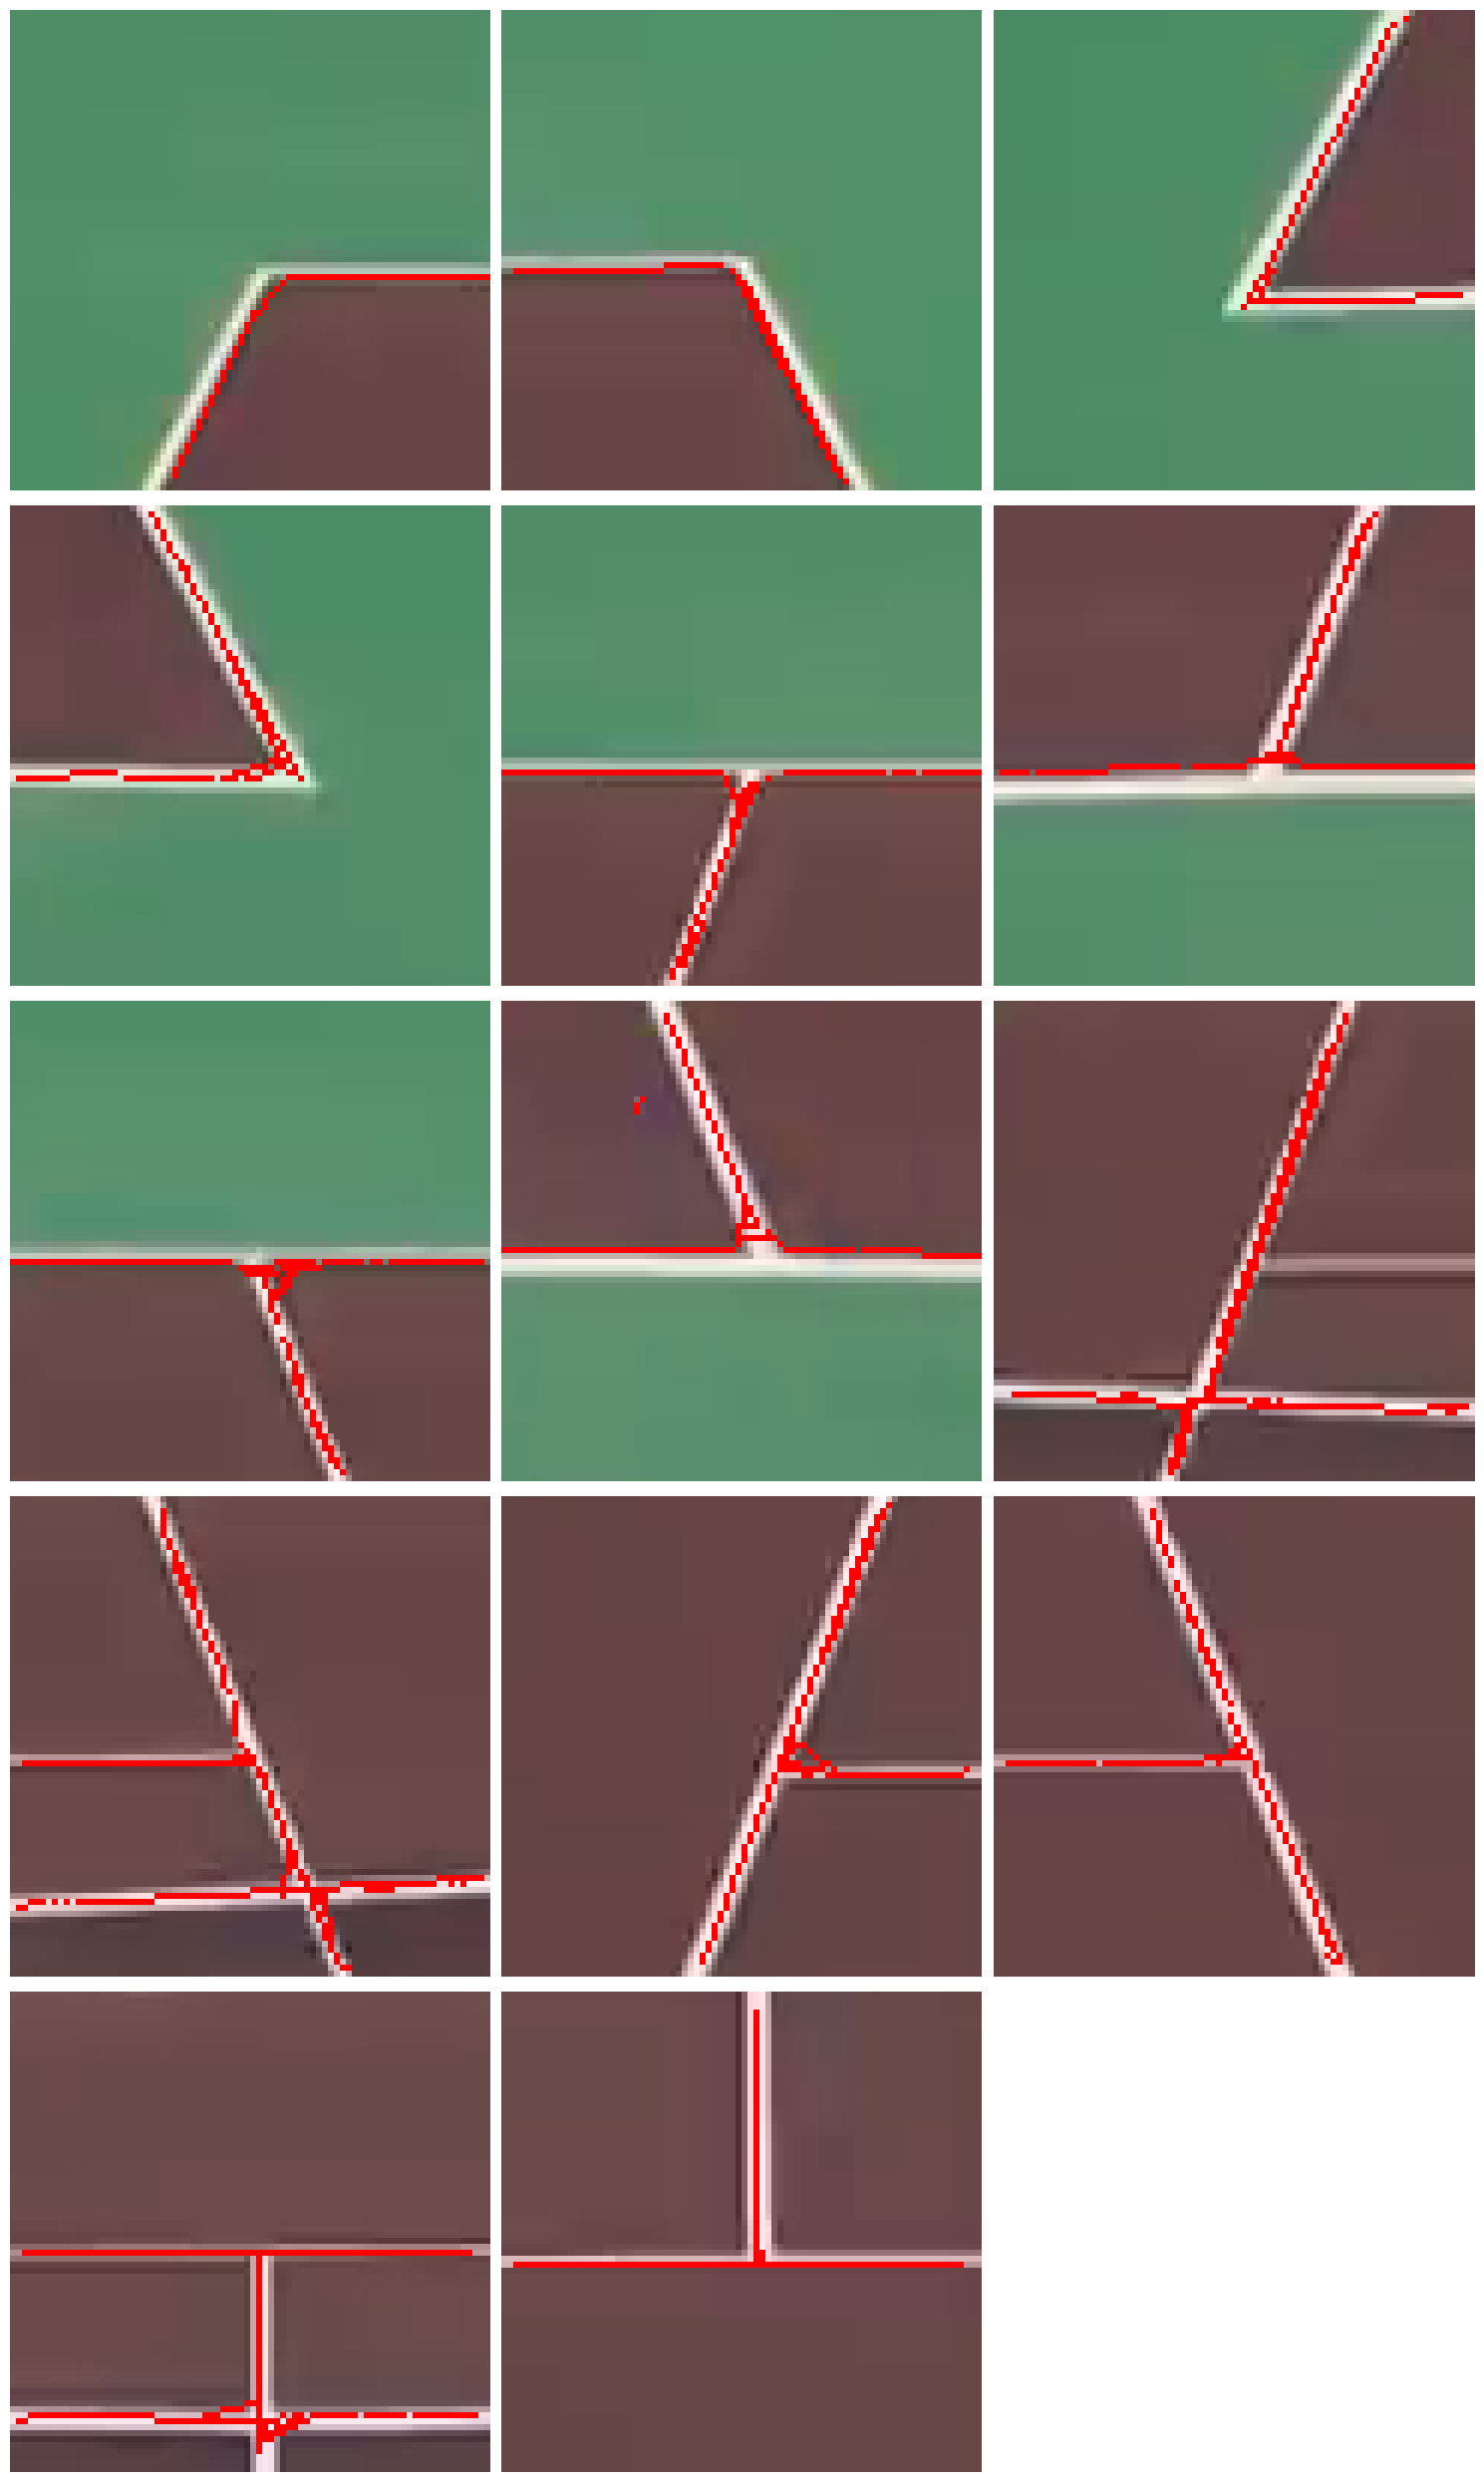

In [663]:
n_keypoints = len(keypoints)
n_cols = 3
n_rows = (n_keypoints + n_cols - 1) // n_cols

linesP = []
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
for i, skeleton in enumerate(skeletons):

    # Hough Transform - Line Detection
    houghLinesP = cv2.HoughLinesP(skeleton, 1, np.pi / 180, 3, minLineLength=0, maxLineGap=7)

    # Showing the detected hough lines
    crop_copy = cropped_images[i].copy()
    if houghLinesP is not None:
        houghLinesP = np.squeeze(houghLinesP)
        for line in houghLinesP:
            x1, y1, x2, y2 = line
            cv2.line(crop_copy, (x1, y1), (x2, y2), (255, 0, 0), 1)
        linesP.append(houghLinesP)

    row, col = divmod(i, n_cols)
    axs[row, col].imshow(crop_copy, cmap='gray')
    axs[row, col].axis('off')

for j in range(i + 1, n_rows * n_cols):
    row, col = divmod(j, n_cols)
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

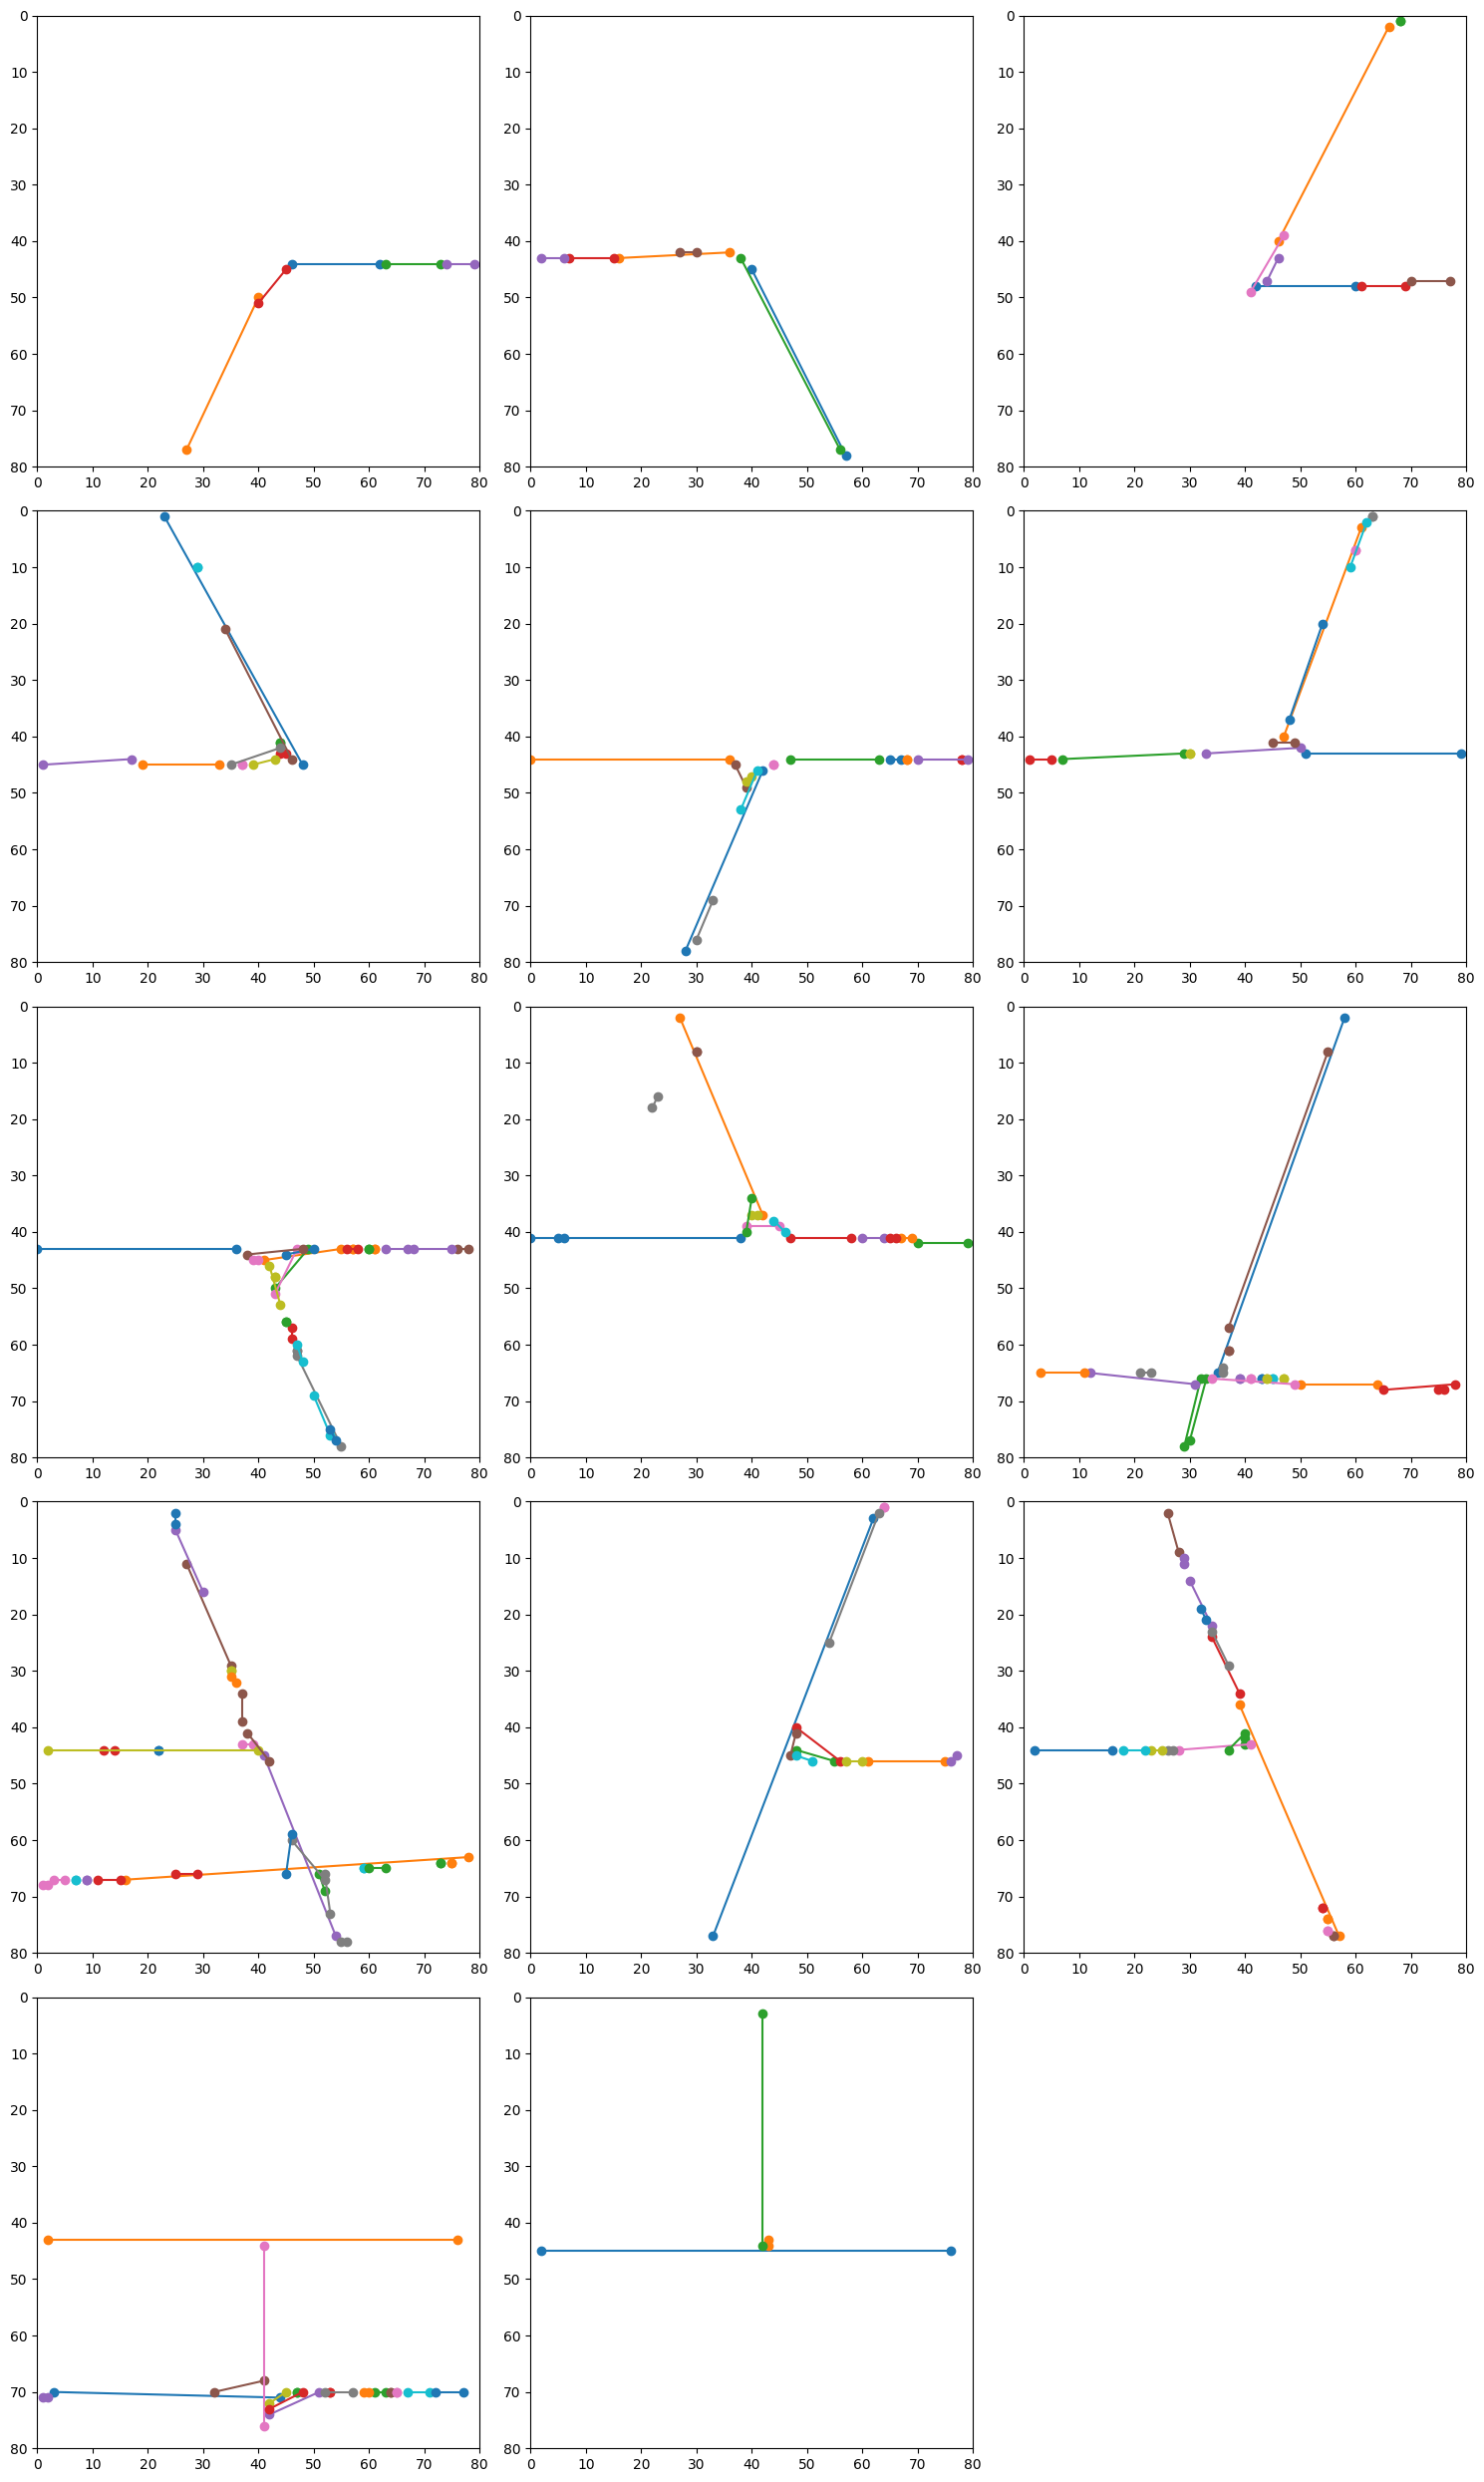

In [664]:
n_keypoints = len(keypoints)
n_cols = 3
n_rows = (n_keypoints + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

for i, edge in enumerate(edges):
    crop_copy2 = cropped_images[i].copy()
    actual_lines = linesP[i]

    row, col = divmod(i, n_cols)
    ax = axs[row, col]

    for line in actual_lines:
        x1, y1, x2, y2 = line
        ax.plot([x1, x2], [y1, y2], marker='o')

    ax.set_xlim(0, crop_copy2.shape[1])
    ax.set_ylim(0, crop_copy2.shape[0])
    ax.invert_yaxis()

for j in range(i + 1, n_rows * n_cols):
    row, col = divmod(j, n_cols)
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()